In [1]:
# Misc imports
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')
import torch
torch.set_printoptions(linewidth=200)
import seaborn as sns
sns.set_style("darkgrid")
import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
       '/storage'
))
import yaml
from pathlib import Path
# Local imports
from ese.scripts.utils import get_option_product
from ese.experiment.analysis.run_inference import get_cal_stats
from ese.experiment.analysis.analysis_utils.submit_utils import get_ese_inference_configs
# Ionpy imports
from ionpy.util import Config
from ionpy.analysis import ResultsLoader

# Define some useful paths.
scratch_root = Path("/storage/vbutoi/scratch/ESE")
code_root = Path("/storage/vbutoi/projects/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

/storage/vbutoi/projects/ionpy/pandas/register.py:47: UserWarning: registration of accessor <class 'ionpy.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'fillNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/projects/ionpy/pandas/register.py:47: UserWarning: registration of accessor <class 'ionpy.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'isNA' for type <class 'pandas.core.series.Series'> is overriding a preexisting attribute with the same name.
  register_series_accessor(method.__name__)(AccessorMethod)
/storage/vbutoi/projects/ionpy/pandas/register.py:47: UserWarning: registration of accessor <class 'ionpy.pandas.register.register_series_method.<locals>.inner.<locals>.AccessorMethod'> under name 'notNA' for type <class 'pandas.core.series.Series'> is overriding 

In [2]:
%%yaml inference_config


experiment:
    exp_root: '?'
    seed: 40
    threshold: 0.5 
    max_ensemble_samples: 5

log:
    root: '?'
    min_fg_pixels: 0 
    log_interval: 10 
    save_preds: False
    log_image_stats: True 
    log_pixel_stats: True 
    gether_inference_stats: True
    track_ensemble_member_scores: False 
    summary_compute_global_metrics: True

dataloader:
    batch_size: 1 
    num_workers: 0
    pin_memory: True 

<IPython.core.display.Javascript object>

In [3]:
%%yaml calibration_cfg 

calibrator:
    _name: '?'
    normalize: False

local_calibration:
    num_prob_bins: 15
    neighborhood_width: 3
    square_diff: False 

global_calibration:
    num_prob_bins: 15
    num_classes: 2
    neighborhood_width: 3
    square_diff: False 
    loss_weights: None 

<IPython.core.display.Javascript object>

In [4]:
%%yaml standard_model_cfg 

# For standard datasets
#####################################
data:
    splits: ('val', 'cal')
    preload: False 

ensemble:
    combine_fn: 'mean'
    combine_quantity: 'probs'
    normalize: False
    num_members: 5

model:
    _type: "standard"
    pretrained_exp_root : None
    checkpoint: '?'
    pretrained_select_metric: "val-dice_score"
    pred_label: 1

<IPython.core.display.Javascript object>

In [5]:
exp_name = '06_04_24_WMH_DifferenceExps'
group_dict = {
    "datasets": [
        "WMH"
    ],
    "exp_group": exp_name,
    "model_type": "standard",
    "base_models_group": "/storage/vbutoi/scratch/ESE/training/01_03_24_WMH_Ensemble",
    "calibrated_models_group": "/storage/vbutoi/scratch/ESE/calibration/January_2024/01_18_24_WMH_All_Calibrators",
    "scratch_root": "/storage/vbutoi/scratch/ESE",
    "inf_cfg_root": "/storage/vbutoi/projects/ESE/ese/experiment/configs/inference",
}

## Gather Inference Options.

In [6]:
%%yaml inference_config_opts

calibrator:
    - Uncalibrated
    - TempScaling
    - LTS

do_ensemble:
    - False

<IPython.core.display.Javascript object>

In [7]:
# Load the inference cfg from local.
##################################################
inf_cfg_root = code_root / "ese" / "experiment" / "configs" / "inference"

##################################################
with open(inf_cfg_root / "Calibration_Metrics.yaml", 'r') as file:
    cal_metrics_cfg = yaml.safe_load(file)

##################################################
base_cfg = Config(inference_config).update([calibration_cfg, cal_metrics_cfg, standard_model_cfg])

In [8]:
# Get the configs for the different runs.
inf_cfgs = get_ese_inference_configs(
    group_dict=group_dict,
    base_cfg=base_cfg,
    inf_cfg_opts=inference_config_opts
)

WARNING! Calibrator not found, using default calibrator name: Uncalibrated.


In [9]:
len(inf_cfgs)

12

## Running Jobs

In [10]:
from ese.experiment.analysis.run_inference import get_cal_stats

Set seed: 43


/storage/vbutoi/projects/ionpy/util/libcheck.py:49: UserWarning: Intel MKL extensions not available for NumPy
  warn("Intel MKL extensions not available for NumPy")
/storage/vbutoi/projects/ionpy/util/libcheck.py:57: UserWarning: Using slow Pillow instead of Pillow-SIMD
  warn("Using slow Pillow instead of Pillow-SIMD")


Set seed: 40
Running:

calibrator:
  _class: Uncalibrated
  _name: Uncalibrated
  normalize: false
data:
  input_type: volume
  preload: false
  slicing: dense_full
  splits: ('val', 'cal')
dataloader:
  batch_size: 1
  num_workers: 0
  pin_memory: true
dataset:
  _class: ese.experiment.datasets.WMH
  annotator: observer_o12
  augmentations: null
  axis: 0
  num_slices: 1
  preload: false
  return_data_id: true
  slicing: dense_full
  task: Amsterdam
  version: 0.2
do_ensemble: false
ensemble:
  combine_fn: null
  combine_quantity: null
  normalize: null
  num_members: 5
experiment:
  dataset_name: WMH
  exp_name: 06_04_24_WMH_DifferenceExps
  exp_root: /storage/vbutoi/scratch/ESE/inference/06_04_24_WMH_DifferenceExps
  max_ensemble_samples: 5
  pretrained_seed: 43
  seed: 40
  threshold: 0.5
global_cal_metrics:
- ECE:
    _fn: ese.experiment.metrics.calibration.ece_loss
    cal_type: toplabel
- Edge-ECE:
    _fn: ese.experiment.metrics.calibration.edge_ece_loss
    cal_type: toplabel


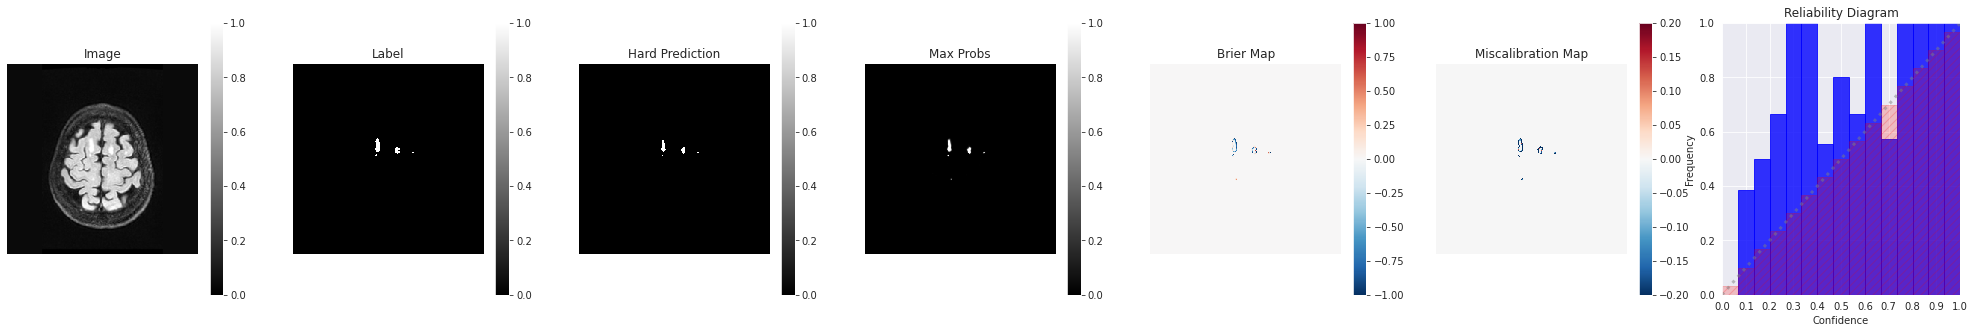

Dice: 0.804780900478363
HD95: 1.124264121055603
BoundaryIOU: 0.6733333468437195
Accuracy: 0.9992523193359375
SoftVolumeError: -31.280189514160156
HardVolumeError: -39.0
Image_ECE: 0.000504303968704455
Image_Edge-ECE: 0.14748440138078978
Image_CW-ECE: 0.0005043039564043283
Image_ECW-ECE: 0.12224724888801575
Image_Uniform-CW-ECE: 0.0005043039564043283
Image_Uniform-ECW-ECE: 0.12224724888801575
Data counter:  0


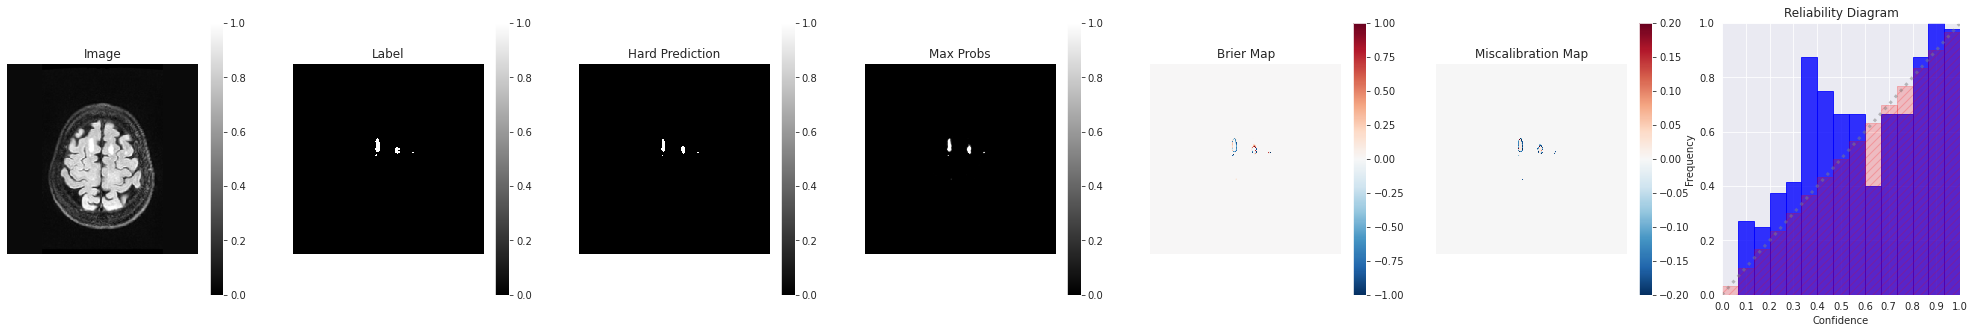

Dice: 0.8257575631141663
HD95: 1.0
BoundaryIOU: 0.7032257914543152
Accuracy: 0.999298095703125
SoftVolumeError: -13.504409790039062
HardVolumeError: -26.0
Image_ECE: 0.00030385491273002936
Image_Edge-ECE: 0.10011743158436123
Image_CW-ECE: 0.00030385490390472114
Image_ECW-ECE: 0.07983197271823883
Image_Uniform-CW-ECE: 0.00030385490390472114
Image_Uniform-ECW-ECE: 0.07983197271823883
Data counter:  1


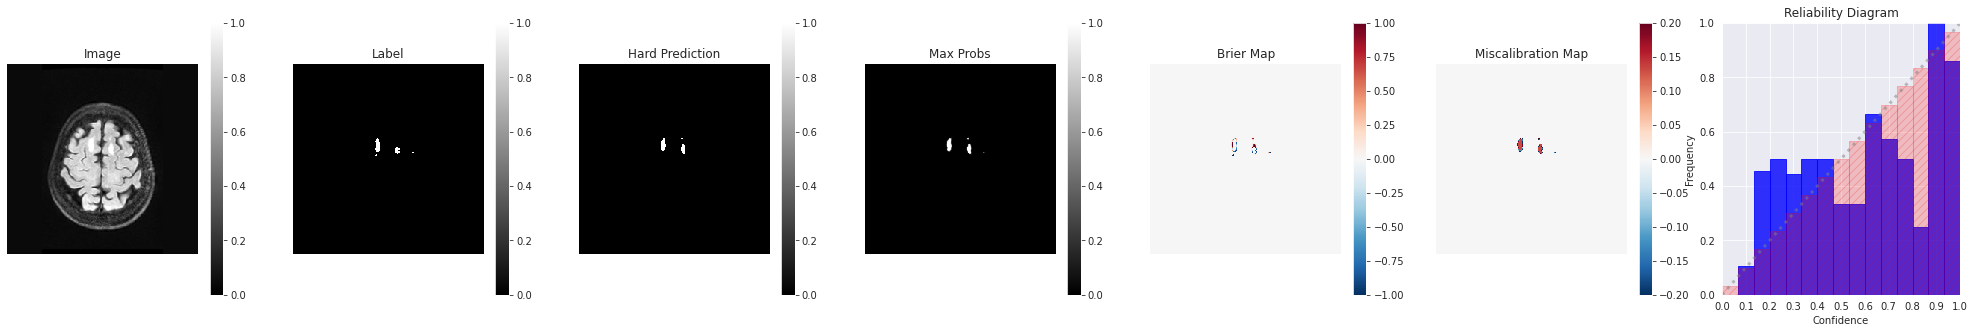

Dice: 0.7692307829856873
HD95: 4.908113956451416
BoundaryIOU: 0.625
Accuracy: 0.998992919921875
SoftVolumeError: 5.29833984375
HardVolumeError: -4.0
Image_ECE: 0.000602400847741073
Image_Edge-ECE: 0.17997332969108656
Image_CW-ECE: 0.0006024008616805077
Image_ECW-ECE: 0.1416620910167694
Image_Uniform-CW-ECE: 0.0006024008616805077
Image_Uniform-ECW-ECE: 0.1416620910167694
Data counter:  2


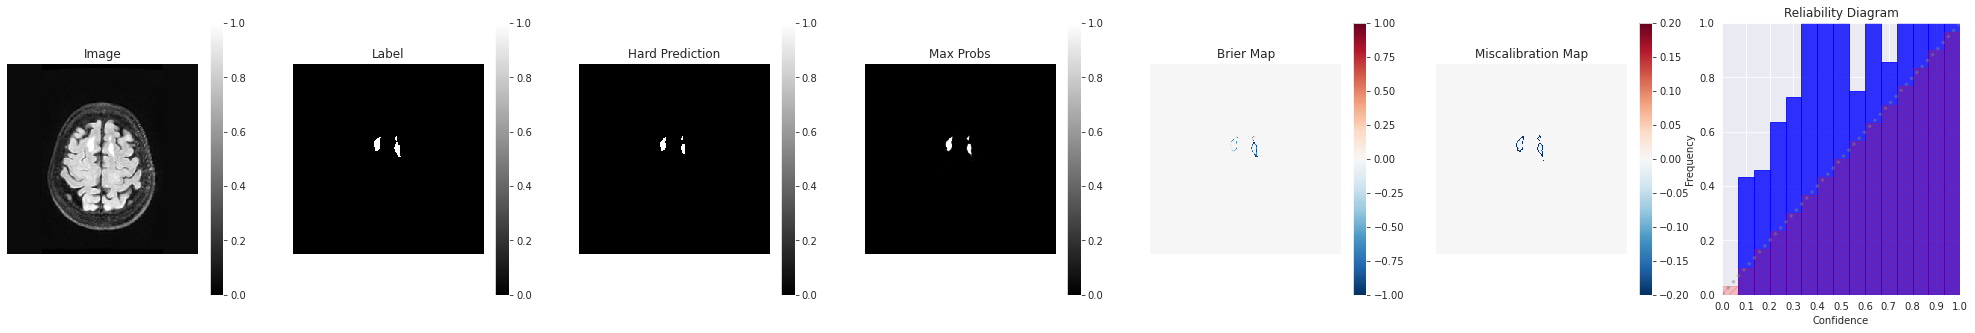

Dice: 0.8309178948402405
HD95: 2.0
BoundaryIOU: 0.71074378490448
Accuracy: 0.998931884765625
SoftVolumeError: -53.719879150390625
HardVolumeError: -66.0
Image_ECE: 0.0008197001258165817
Image_Edge-ECE: 0.18599836407769565
Image_CW-ECE: 0.0008197001297958195
Image_ECW-ECE: 0.14183858036994934
Image_Uniform-CW-ECE: 0.0008197001297958195
Image_Uniform-ECW-ECE: 0.14183858036994934
Data counter:  3


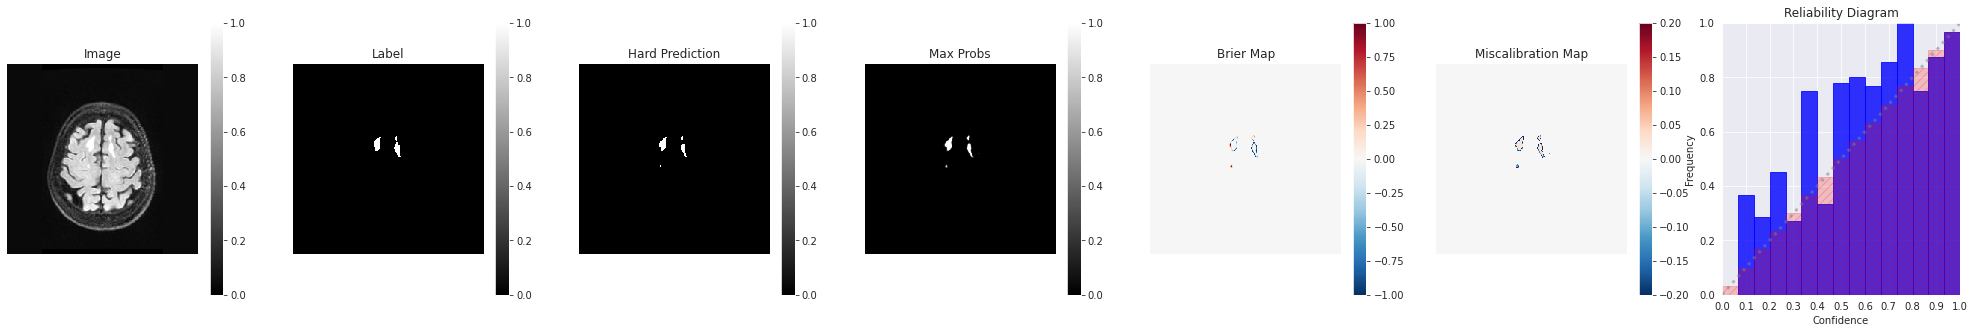

Dice: 0.8539325594902039
HD95: 1.4142135381698608
BoundaryIOU: 0.7450980544090271
Accuracy: 0.9990081787109375
SoftVolumeError: -27.785552978515625
HardVolumeError: -35.0
Image_ECE: 0.0005944703265459252
Image_Edge-ECE: 0.15047636602065032
Image_CW-ECE: 0.0005944703007116914
Image_ECW-ECE: 0.10949571430683136
Image_Uniform-CW-ECE: 0.0005944703007116914
Image_Uniform-ECW-ECE: 0.10949571430683136
Data counter:  4


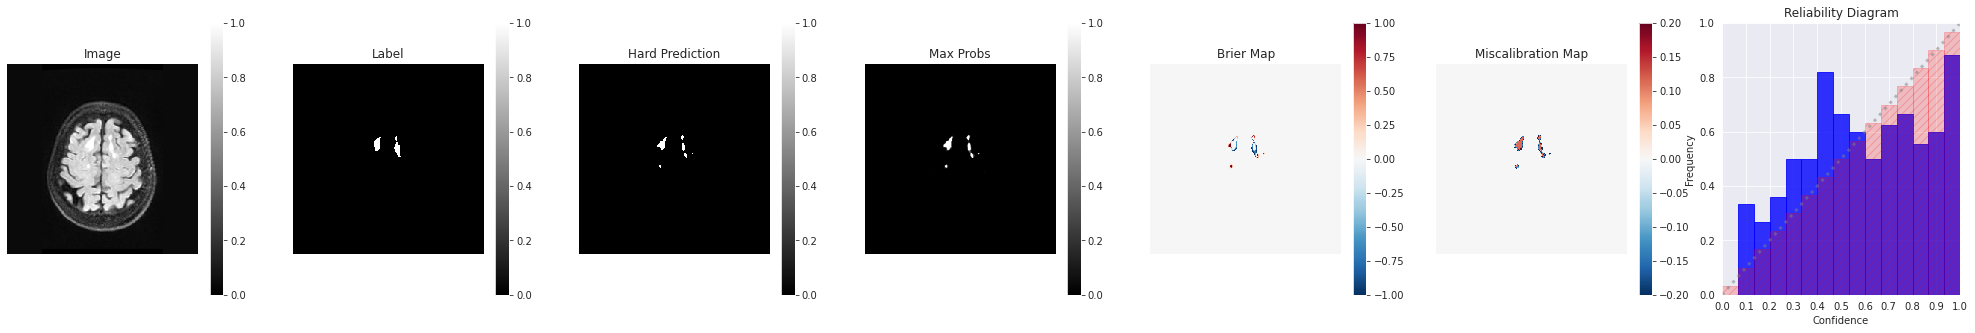

Dice: 0.7247706651687622
HD95: 7.708596229553223
BoundaryIOU: 0.568345308303833
Accuracy: 0.9981689453125
SoftVolumeError: -22.227508544921875
HardVolumeError: -44.0
Image_ECE: 0.0010841563320987473
Image_Edge-ECE: 0.21480067160259542
Image_CW-ECE: 0.001084156334400177
Image_ECW-ECE: 0.17403078079223633
Image_Uniform-CW-ECE: 0.001084156334400177
Image_Uniform-ECW-ECE: 0.17403078079223633
Data counter:  5


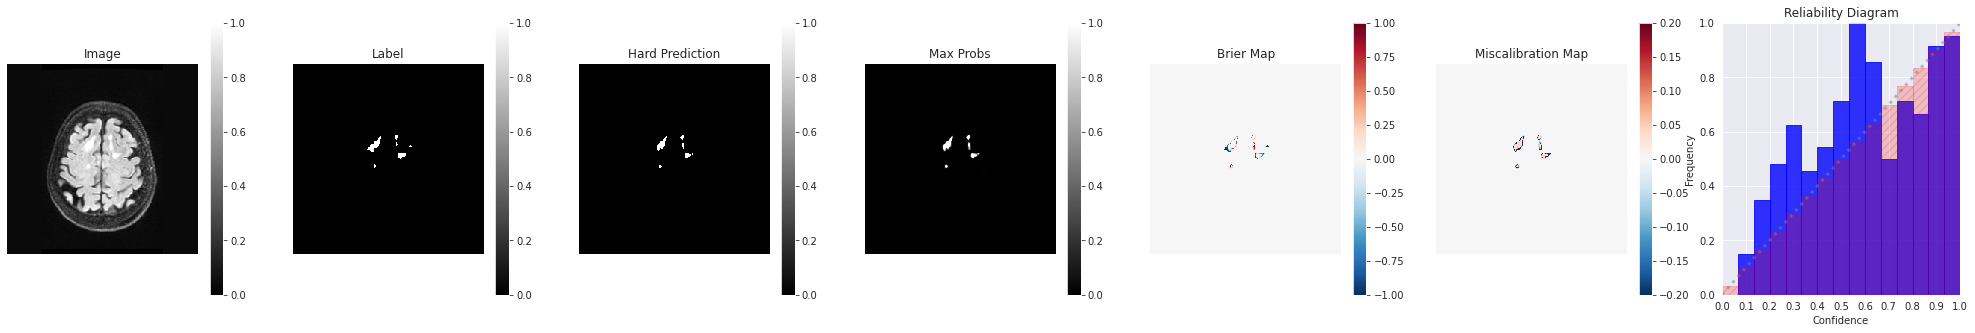

Dice: 0.7950819730758667
HD95: 3.0
BoundaryIOU: 0.6598639488220215
Accuracy: 0.99847412109375
SoftVolumeError: -31.732208251953125
HardVolumeError: -48.0
Image_ECE: 0.0008259585866840152
Image_Edge-ECE: 0.14450167988823698
Image_CW-ECE: 0.0008259585592895746
Image_ECW-ECE: 0.1258082389831543
Image_Uniform-CW-ECE: 0.0008259585592895746
Image_Uniform-ECW-ECE: 0.1258082389831543
Data counter:  6


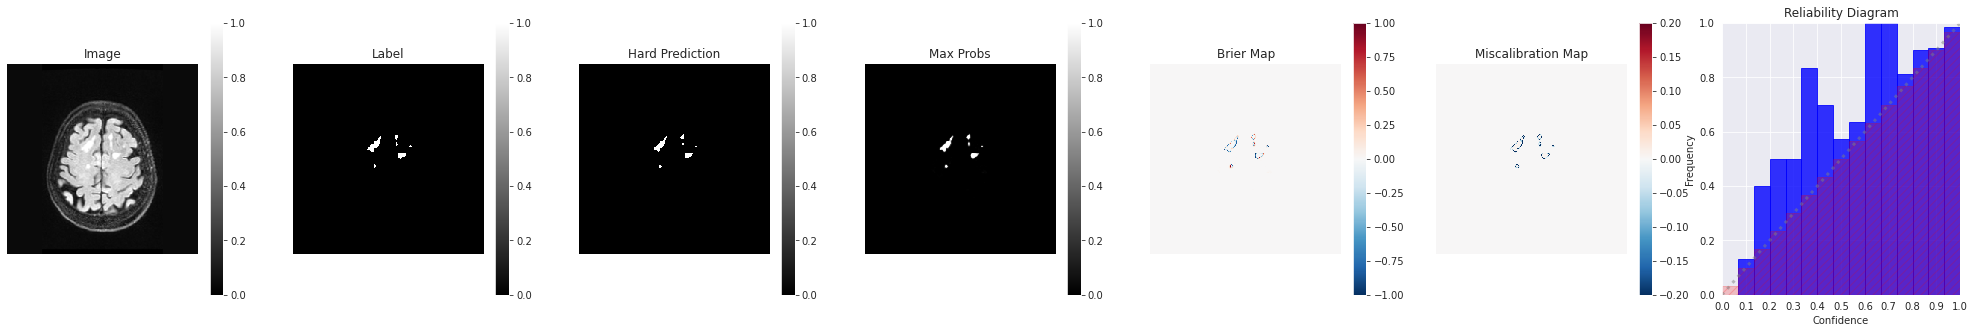

Dice: 0.8606060743331909
HD95: 1.0
BoundaryIOU: 0.7553191781044006
Accuracy: 0.9989471435546875
SoftVolumeError: -25.39849853515625
HardVolumeError: -41.0
Image_ECE: 0.0005149476555189157
Image_Edge-ECE: 0.0878625018582325
Image_CW-ECE: 0.0005149476346559823
Image_ECW-ECE: 0.06785402446985245
Image_Uniform-CW-ECE: 0.0005149476346559823
Image_Uniform-ECW-ECE: 0.06785402446985245
Data counter:  7


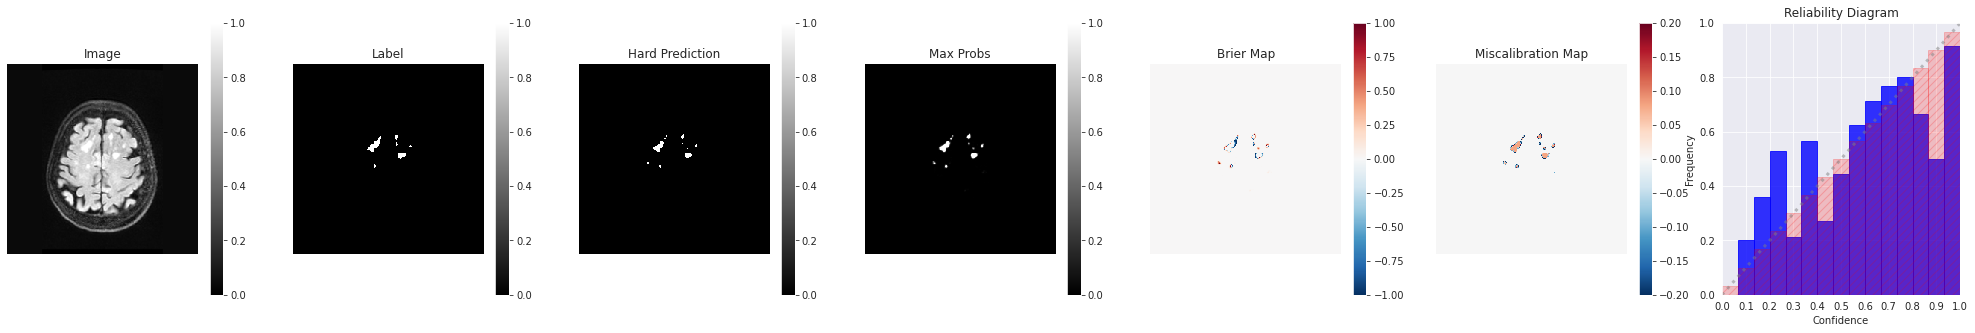

Dice: 0.7730061411857605
HD95: 2.0590169429779053
BoundaryIOU: 0.6299999952316284
Accuracy: 0.9983062744140625
SoftVolumeError: -19.613876342773438
HardVolumeError: -47.0
Image_ECE: 0.0009436431443278482
Image_Edge-ECE: 0.16992596461041293
Image_CW-ECE: 0.0009436431573703885
Image_ECW-ECE: 0.14355847239494324
Image_Uniform-CW-ECE: 0.0009436431573703885
Image_Uniform-ECW-ECE: 0.14355847239494324
Data counter:  8


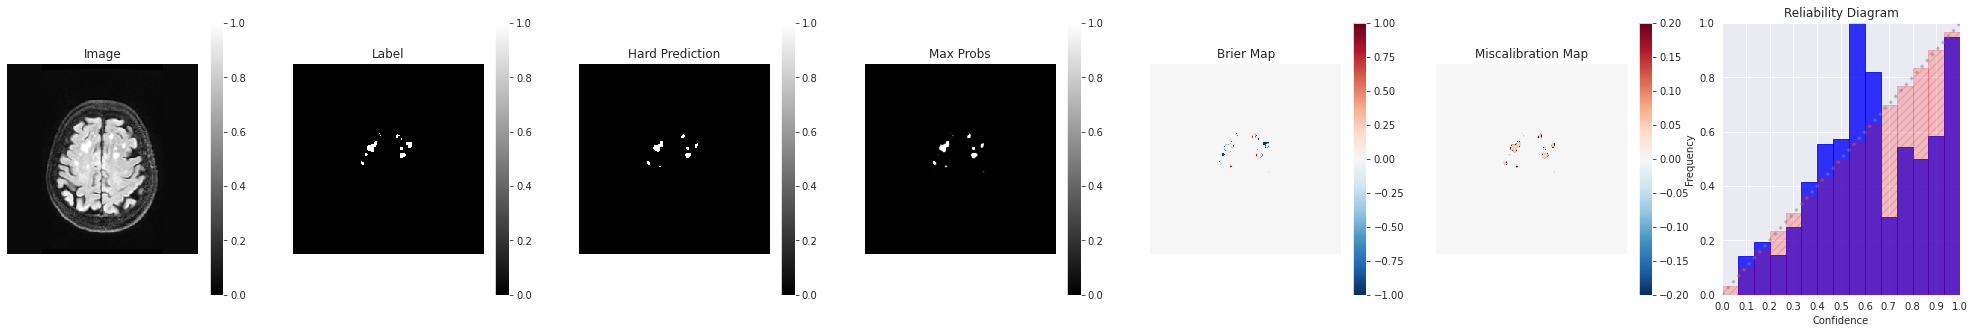

Dice: 0.8041236996650696
HD95: 5.830951690673828
BoundaryIOU: 0.6724137663841248
Accuracy: 0.9985504150390625
SoftVolumeError: -0.665771484375
HardVolumeError: -23.0
Image_ECE: 0.0007717534122697615
Image_Edge-ECE: 0.11816559230417527
Image_CW-ECE: 0.0007717534317635
Image_ECW-ECE: 0.10818777978420258
Image_Uniform-CW-ECE: 0.0007717534317635
Image_Uniform-ECW-ECE: 0.10818777978420258
Data counter:  9


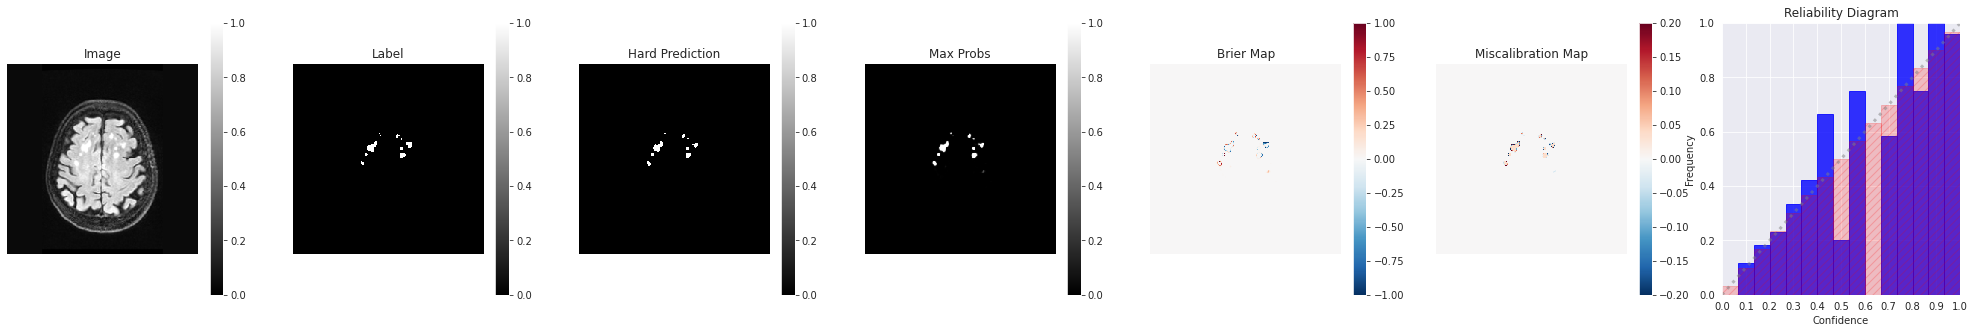

Dice: 0.8594704866409302
HD95: 1.0
BoundaryIOU: 0.7535714507102966
Accuracy: 0.9989471435546875
SoftVolumeError: 5.1239013671875
HardVolumeError: -17.0
Image_ECE: 0.0003727540487922685
Image_Edge-ECE: 0.06866694377721463
Image_CW-ECE: 0.00037275406066328287
Image_ECW-ECE: 0.059388384222984314
Image_Uniform-CW-ECE: 0.00037275406066328287
Image_Uniform-ECW-ECE: 0.059388384222984314
Data counter:  10


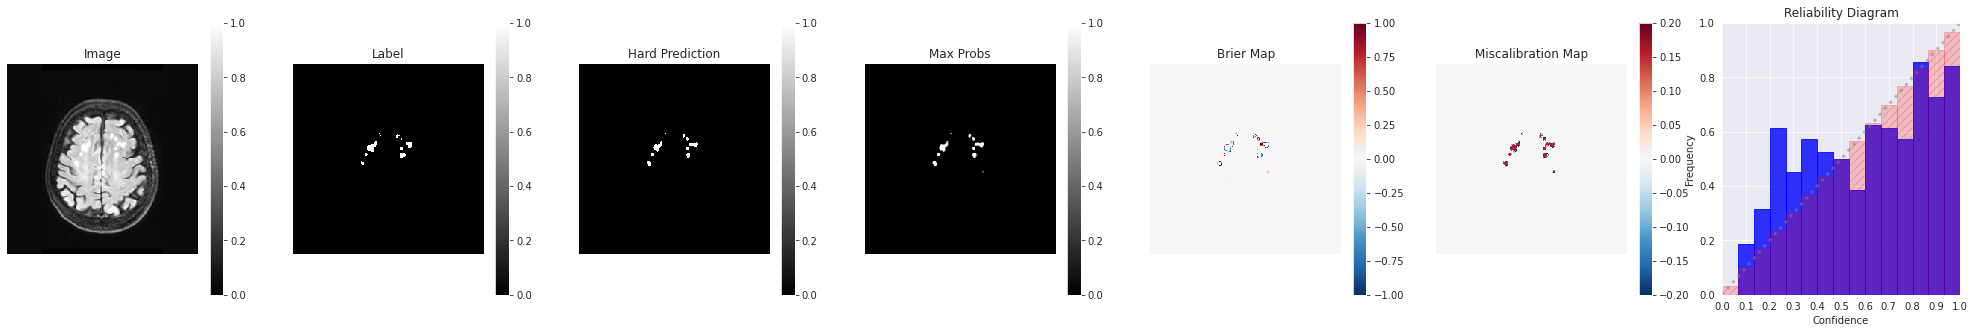

Dice: 0.750507116317749
HD95: 2.0
BoundaryIOU: 0.600649356842041
Accuracy: 0.9981231689453125
SoftVolumeError: 13.15216064453125
HardVolumeError: -15.0
Image_ECE: 0.0009132674651744043
Image_Edge-ECE: 0.13642364600798798
Image_CW-ECE: 0.0009132674895226955
Image_ECW-ECE: 0.10871630162000656
Image_Uniform-CW-ECE: 0.0009132674895226955
Image_Uniform-ECW-ECE: 0.10871630162000656
Data counter:  11


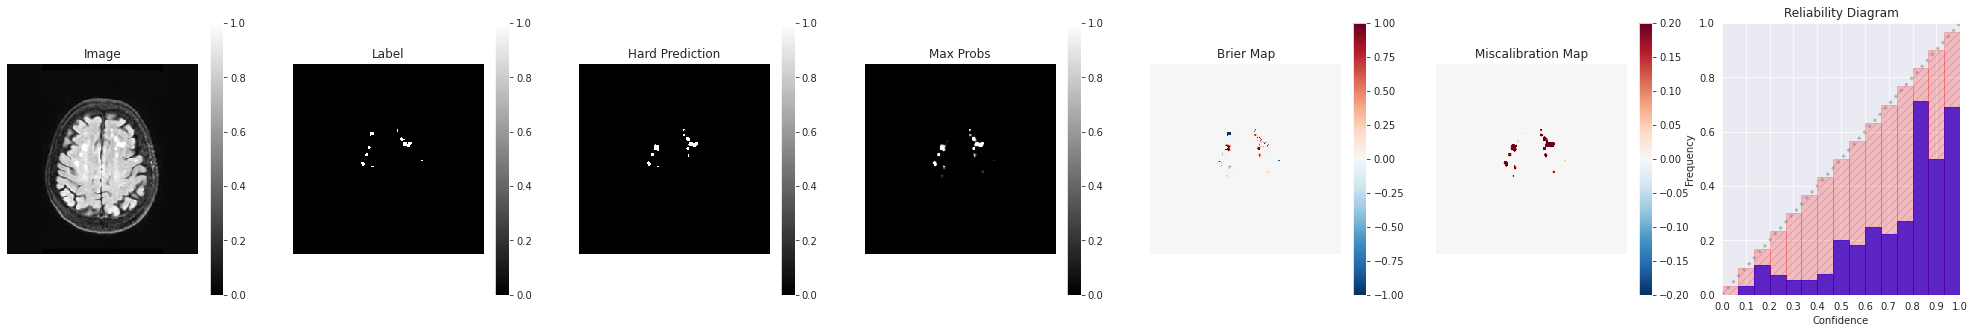

Dice: 0.6630434989929199
HD95: 16.1011905670166
BoundaryIOU: 0.49593496322631836
Accuracy: 0.99810791015625
SoftVolumeError: 77.25241088867188
HardVolumeError: 44.0
Image_ECE: 0.0016874152779948566
Image_Edge-ECE: 0.17718505266034565
Image_CW-ECE: 0.001687415293417871
Image_ECW-ECE: 0.17306973040103912
Image_Uniform-CW-ECE: 0.001687415293417871
Image_Uniform-ECW-ECE: 0.17306973040103912


KeyboardInterrupt: 

In [11]:
from ese.experiment.experiment import run_ese_exp

###### Run individual jobs
run_ese_exp(
    config=inf_cfgs[0], 
    job_func=get_cal_stats,
    run_name='debug',
    show_examples=True,
    gpu='0',
) 

In [ ]:
# from ese.experiment.experiment import submit_ese_exps 

# #### Run Batch Jobs
# submit_ese_exps(
#     config_list=inf_cfgs,
#     job_func=get_cal_stats,
#     available_gpus=['0', '1', '2', '3'],
# )